In [61]:
import dask
import doppyo
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

import warnings
warnings.filterwarnings("ignore")

# Spin up a cluster

In [88]:
cluster = SLURMCluster(walltime='1:00:00', cores=5, memory='30GB', job_extra=['--qos="express"'])

In [89]:
cluster.scale(n=1)

In [90]:
client = Client(cluster)
client

Client Scheduler: tcp://152.83.81.91:42235 Dashboard: http://152.83.81.91:32997/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Notebook specific functions

In [65]:
def similarize(ds, transform_names=None, scale_by=None, time_truncation_freq=False, fix_longitudes=False, time_name='time'):
    """ 
        Make the various datasets look similar 
    """
    
    def _to_datetime64(times, freq):
        if not np.issubdtype(times.dtype, np.datetime64):
            times_datetime64 = np.array([
                np.datetime64(str(time.year)+'-'+
                              str(time.month).zfill(2)+'-'+
                              str(time.day).zfill(2)) for time in times
                                        ])
        times_datetime64 = times.astype('<M8['+freq+']')
        return times_datetime64

    if transform_names is not None:
        ds = ds.rename(transform_names)
        
    if scale_by is not None:
        for variable, factor in scale_by.items():
            ds[variable] = factor * ds[variable]
    
    if (time_name in ds.coords) & isinstance(time_truncation_freq, str):
        cf_time = xr.coding.times.decode_cf_datetime(ds[time_name], 
                                                     units=ds[time_name].attrs['units'],
                                                     calendar=ds[time_name].attrs['calendar'],
                                                     use_cftime=True)
        
#         if time_truncation_freq == 'D':
#             cf_time =  np.array([time.replace(hour=0, minute=0, second=0, microsecond=0) 
#                                  for time in cf_time])
#         if time_truncation_freq == 'M':
#             cf_time =  np.array([time.replace(day=1, hour=0, minute=0, second=0, microsecond=0) 
#                                  for time in cf_time])
        
        # Force to be within np.datetime64 range ----
        min_year = cf_time[0].year - 1
        max_year = cf_time[-1].year - 1
        if (min_year < 1678):
            cf_time =  np.array([time.replace(year=time.year+1678-min_year) 
                                 for time in cf_time])

        ds[time_name].values = _to_datetime64(cf_time, time_truncation_freq)

        if 'calendar' in ds[time_name].attrs:
            ds[time_name].attrs['orgl_calendar'] = ds[time_name].attrs.pop('calendar')
        if 'calendar_type' in ds[time_name].attrs:
            ds[time_name].attrs['orgl_calendar_type'] = ds[time_name].attrs.pop('calendar_type')
        if 'units' in ds[time_name].attrs:
            ds[time_name].attrs['orgl_units'] = ds[time_name].attrs.pop('units')

        if 'units' in ds[time_name].encoding:
            ds[time_name].encoding.pop('units')
        if 'calendar' in ds[time_name].encoding:
            ds[time_name].encoding.pop('calendar')
            
    if fix_longitudes:
        lon_names = doppyo.utils.get_lon_name(ds)
        if isinstance(lon_names, list):
            for lon_name in lon_names:
                ds = ds.assign_coords({lon_name: (ds[lon_name] + 360)  % 360}).sortby(lon_name)
        else:
            lon_name = lon_names
            ds = ds.assign_coords({lon_name: (ds[lon_name] + 360)  % 360}).sortby(lon_name)

    return ds

In [66]:
def month_climatology(ds, time_name='time'):
    if 'ensemble' in ds.dims:
        return ds.groupby(time_name+'.month', squeeze=False).mean(dim=[time_name,'ensemble'])
    else:
        return ds.groupby(time_name+'.month', squeeze=False).mean(dim=time_name)

In [67]:
def month_anomaly(ds, ds_clim=None, time_name='time'):

    if ds_clim is None:
        ds_clim = month_climatology(ds, time_name=time_name)
        
    return (doppyo.utils.prune(ds).groupby(time_name+'.month') - 
            doppyo.utils.prune(ds_clim)).drop('month')

In [68]:
def get_month_anomalies(full_field, clim_fields, save_name, time_name='time', compute=False, save_chunks=False):
    
    variable = full_field.name
    
    if compute: 
        anom = []
        for clim_name, clim_field in clim_fields.items():
            anom.append(month_anomaly(full_field, clim_field, time_name=time_name).rename(variable + '_' + clim_name))
        anoms = xr.merge(anom)
        if save_chunks:
            anoms = anoms.chunk(save_chunks)
        anoms.to_zarr(tmp_dir + save_name + '.zarr', mode='w', consolidated=True) 
        
    return xr.open_zarr(tmp_dir + save_name + '.zarr', consolidated=True)

In [69]:
def get_diagnostic(diagnostic_function, kwargs, save_name, save_type='zarr', mean_and_std_only=False, 
                   compute=False, convert_to_dataset=False, save_chunks=False):
    """ 
        If mean_and_std_only = True, returns two outputs (the mean and std)
    """
    if compute:
        if mean_and_std_only:
            print('Computing ensemble mean of diagnostic...')
            diagnostic = diagnostic_function(**kwargs)
            diagnostic_ensmean = diagnostic.mean('ensemble')
            if save_type == 'zarr':
                if save_chunks:
                    diagnostic_ensmean = diagnostic_ensmean.chunk(save_chunks)
                if convert_to_dataset:
                    diagnostic_ensmean.to_dataset(name=convert_to_dataset).to_zarr(tmp_dir + save_name + '_ensmean.zarr', 
                                                                                   mode='w', 
                                                                                   consolidated=True)
                else:
                    diagnostic_ensmean.to_zarr(tmp_dir + save_name + '_ensmean.zarr', mode='w', consolidated=True) 
            elif save_type == 'nc':
                if convert_to_dataset:
                    diagnostic_ensmean.to_dataset(name=convert_to_dataset).to_netcdf(tmp_dir + save_name + '_ensmean.nc') 
                else:
                    diagnostic_ensmean.to_netcdf(tmp_dir + save_name + '_ensmean.nc') 
            else:
                raise ValueError('Unrecognised file type')
                
            print('Computing ensemble std of diagnostic...')
            diagnostic_ensstd = diagnostic.std('ensemble')
            if save_type == 'zarr':
                if save_chunks:
                    diagnostic_ensstd = diagnostic_ensstd.chunk(save_chunks) 
                if convert_to_dataset:
                    diagnostic_ensstd.to_dataset(name=convert_to_dataset).to_zarr(tmp_dir + save_name+ '_ensstd.zarr', 
                                                                                  mode='w', 
                                                                                  consolidated=True)
                else:
                    diagnostic_ensstd.to_zarr(tmp_dir + save_name+ '_ensstd.zarr', mode='w', consolidated=True)
            elif save_type == 'nc':
                if convert_to_dataset:
                    diagnostic_ensstd.to_dataset(name=convert_to_dataset).to_netcdf(tmp_dir + save_name+ '_ensstd.nc')
                else:
                    diagnostic_ensstd.to_netcdf(tmp_dir + save_name+ '_ensstd.nc')
            else:
                raise ValueError('Unrecognised file type')
        else:
            print('Computing diagnostic...')
            diagnostic = diagnostic_function(**kwargs)
            if save_type == 'zarr':
                if save_chunks:
                    diagnostic = diagnostic.chunk(save_chunks)
                if convert_to_dataset:
                    diagnostic.to_dataset(name=convert_to_dataset).to_zarr(tmp_dir + save_name + '.zarr', 
                                                                           mode='w', 
                                                                           consolidated=True) 
                else:
                    diagnostic.to_zarr(tmp_dir + save_name + '.zarr', mode='w', consolidated=True) 
            elif save_type == 'nc':
                if convert_to_dataset:
                    diagnostic.to_dataset(name=convert_to_dataset).to_netcdf(tmp_dir + save_name + '.nc')
                else:
                    diagnostic.to_netcdf(tmp_dir + save_name + '.nc')
            else:
                raise ValueError('Unrecognised file type')
   
    if mean_and_std_only:
        if save_type == 'zarr':
            return xr.open_zarr(tmp_dir + save_name + '_ensmean.zarr', consolidated=True), \
                   xr.open_zarr(tmp_dir + save_name + '_ensstd.zarr', consolidated=True)
        elif save_type == 'nc':
            return xr.open_dataset(tmp_dir + save_name + '_ensmean.nc', chunks=save_chunks), \
                   xr.open_dataset(tmp_dir + save_name + '_ensstd.nc', chunks=save_chunks)
        else:
            raise ValueError('Unrecognised file type')
    else:
        if save_type == 'zarr':
            return xr.open_zarr(tmp_dir + save_name + '.zarr', consolidated=True)
        elif save_type == 'nc':
            return xr.open_dataset(tmp_dir + save_name + '.nc', chunks=save_chunks)
        else:
            raise ValueError('Unrecognised file type')

# Load the data

In [70]:
jra_name_transform = {'initial_time0_hours' : 'time',
                      'lv_ISBL1' : 'level',
                      'HGT_GDS0_ISBL': 'hght',
                      'PRES_GDS0_SFC': 'ps',
                      'PRMSL_GDS0_MSL': 'slp',
                      'SPFH_GDS0_ISBL': 'sphum',
                      'STRM_GDS0_ISBL': 'psi',
                      'TMAX_GDS4_HTGL': 'tref_max',
                      'TMIN_GDS4_HTGL': 'tref_min',
                      'TMP_GDS0_HTGL': 'tref',
                      'TMP_GDS0_ISBL': 'temp',
                      'TPRAT_GDS0_SFC': 'precip',
                      'UGRD_GDS0_ISBL': 'ucomp',
                      'ULWRF_GDS0_NTAT': 'olr',
                      'VGRD_GDS0_ISBL': 'vcomp',
                      'VPOT_GDS0_ISBL': 'phi',
                      'VVEL_GDS0_ISBL': 'omega'}
jra_scale_by = {'slp': 0.01}
gfdl_scale_by = {'psl': 0.01}

In [71]:
f4_atmos_month = similarize(xr.open_zarr('/scratch1/projects/dcfp/WIP/csiro-dcfp-cafe-f4/atmos_isobaric_month.zarr/',
                                         consolidated=True,
                                         decode_times=False),
                            time_truncation_freq='M',
                            time_name='init_date')
f4_ocean_month = similarize(xr.open_zarr('/scratch1/projects/dcfp/WIP/csiro-dcfp-cafe-f4/ocean_month.zarr',
                                         consolidated=True,
                                         decode_times=False),
                            time_truncation_freq='M',
                            fix_longitudes=True,
                            time_name='init_date')

gfdl_ocean_month = similarize(xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-cmip5dec-gfdl_cm2p1/ocean_month.zarr',
                                           consolidated=True,
                                           decode_times=False),
                              time_truncation_freq='M',
                              fix_longitudes=True,
                              time_name='init_date')
gfdl_atmos_month = similarize(xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-cmip5dec-gfdl_cm2p1/atmos_month.zarr',
                                           consolidated=True,
                                           decode_times=False),
                              scale_by=gfdl_scale_by,
                              time_truncation_freq='M',
                              fix_longitudes=True,
                              time_name='init_date')

cm4_ocean_month = similarize(xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-cmip5dec-cmc_cancm4/ocean_month.zarr',
                                           consolidated=True,
                                           decode_times=False),
                              time_truncation_freq='M',
                              fix_longitudes=True,
                              time_name='init_date')
cm4_atmos_month = similarize(xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-cmip5dec-cmc_cancm4/atmos_month.zarr',
                                           consolidated=True,
                                           decode_times=False),
                              scale_by=gfdl_scale_by,
                              time_truncation_freq='M',
                              fix_longitudes=True,
                              time_name='init_date')

had_ocean_month = similarize(xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-hadisst/hadisst_month.zarr',
                                          consolidated=True,
                                          decode_times=False),
                             time_truncation_freq='M',
                             fix_longitudes=True)

d60_ocean_month = similarize(xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-cafe-d60/ocean_month.zarr',
                                          consolidated=True,
                                          decode_times=False),
                             time_truncation_freq='M',
                             fix_longitudes=True)

jra_atmos_month = similarize(xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-jra55/jra55_month.zarr',
                                          consolidated=True,
                                          decode_times=False),
                             transform_names=jra_name_transform,
                             scale_by=jra_scale_by,
                             time_truncation_freq='M',
                             fix_longitudes=True)

### Test dataset from new forecast run

In [116]:
f5_ocean_month = similarize(xr.open_mfdataset('/scratch1/moo270/F4_test_13022020/ocean_month*.nc', 
                                              decode_times=False),
                            time_truncation_freq='M',
                            fix_longitudes=True)
f5_atmos_month = similarize(xr.open_mfdataset('/scratch1/moo270/F4_test_13022020/atmos_month*.nc', 
                                              decode_times=False),
                            time_truncation_freq='M',
                            fix_longitudes=True)

# It looks like there is something funny happening with sst in the tropics

In [20]:
f4_sst_full = doppyo.diagnostic.nino34(f4_ocean_month['sst']).compute()
f5_sst_full = doppyo.diagnostic.nino34(f5_ocean_month['sst']).compute()
gfdl_sst_full = doppyo.diagnostic.nino34(gfdl_ocean_month['tos']).compute()
cm4_sst_full = doppyo.diagnostic.nino34(cm4_ocean_month['tos']).compute()
had_sst_full = doppyo.diagnostic.nino34(had_ocean_month['sst']).compute()
d60_sst_full = doppyo.diagnostic.nino34(d60_ocean_month['sst']).compute()

In [21]:
f4_sst_anom = month_anomaly(f4_sst_full, time_name='init_date')
f5_sst_anom = month_anomaly(f5_sst_full, time_name='time')
gfdl_sst_anom = month_anomaly(gfdl_sst_full, time_name='init_date')
cm4_sst_anom = month_anomaly(cm4_sst_full, time_name='init_date')
had_sst_anom = month_anomaly(had_sst_full, time_name='time')
d60_sst_anom = month_anomaly(d60_sst_full, time_name='time')

In [22]:
f4_tref_full = doppyo.diagnostic.nino34(f4_atmos_month['t_ref']).compute()
f5_tref_full = doppyo.diagnostic.nino34(f5_atmos_month['t_ref']).compute()
gfdl_tref_full = doppyo.diagnostic.nino34(gfdl_atmos_month['tas']).compute()
cm4_tref_full = doppyo.diagnostic.nino34(cm4_atmos_month['tas']).compute()
jra_tref_full = doppyo.diagnostic.nino34(jra_atmos_month['tref']).compute()

In [23]:
f4_tref_anom = month_anomaly(f4_tref_full, time_name='init_date')
f5_tref_anom = month_anomaly(f5_tref_full, time_name='time')
gfdl_tref_anom = month_anomaly(gfdl_tref_full, time_name='init_date')
cm4_tref_anom = month_anomaly(cm4_tref_full, time_name='init_date')
jra_tref_anom = month_anomaly(jra_tref_full, time_name='time')

In [24]:
f4_slp_full = doppyo.diagnostic.nino34(f4_atmos_month['slp']).compute()
f5_slp_full = doppyo.diagnostic.nino34(f5_atmos_month['slp']).compute()
gfdl_slp_full = doppyo.diagnostic.nino34(gfdl_atmos_month['psl']).compute()
cm4_slp_full = doppyo.diagnostic.nino34(cm4_atmos_month['psl']).compute()
jra_slp_full = doppyo.diagnostic.nino34(jra_atmos_month['slp']).compute()

In [25]:
f4_slp_anom = month_anomaly(f4_slp_full, time_name='init_date')
f5_slp_anom = month_anomaly(f5_slp_full, time_name='time')
gfdl_slp_anom = month_anomaly(gfdl_slp_full, time_name='init_date')
cm4_slp_anom = month_anomaly(cm4_slp_full, time_name='init_date')
jra_slp_anom = month_anomaly(jra_slp_full, time_name='time')

In [84]:
init_date = '1960'

# SST

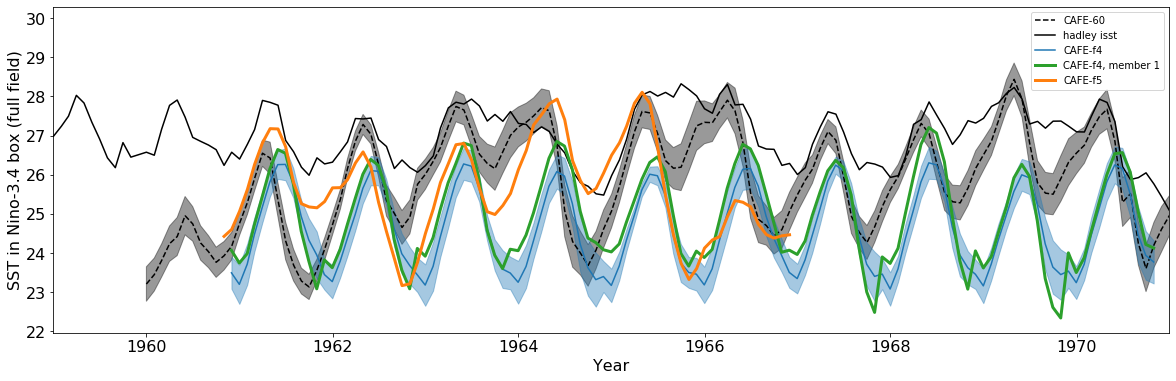

In [132]:
rc_params = {'figure.figsize' : [20.0, 6.0],
             'axes.titlesize' : 'medium',
             'font.size'      : 16,
             'font.family'    : 'sans serif'}
    
with mpl.rc_context(rc=rc_params):
    to_plot = d60_sst_full
    to_plot_mean = to_plot.mean('ensemble')
    to_plot_std = to_plot.std('ensemble')
    plt.fill_between(to_plot.time.values, 
                     to_plot_mean - to_plot_std,
                     to_plot_mean + to_plot_std,
                     color='k', alpha=0.4, label='__nolegend__')
    plt.plot(to_plot.time.values,
             to_plot_mean, color='k', linestyle='--', label='CAFE-60')
    
    to_plot = had_sst_full
    plt.plot(to_plot.time.values,
             to_plot, color='k', label='hadley isst')

#     to_plot = doppyo.utils.leadtime_to_datetime(gfdl_sst_full.sel(init_date=init_date).squeeze()) - 273.15
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C1', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C1', label='gfdl cm2.1, cmip5-decpred')
    
#     to_plot = doppyo.utils.leadtime_to_datetime(cm4_sst_full.sel(init_date=init_date).squeeze()) - 273.15
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C2', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C2', label='cmc cancm4, cmip5-decpred')
    
    to_plot = doppyo.utils.leadtime_to_datetime(f4_sst_full.sel(init_date=init_date).squeeze())
    to_plot_mean = to_plot.mean('ensemble')
    to_plot_std = to_plot.std('ensemble')
    plt.fill_between(to_plot.time.values, 
                     to_plot_mean - to_plot_std,
                     to_plot_mean + to_plot_std,
                     color='C0', alpha=0.4, label='__nolegend__')
    plt.plot(to_plot.time.values,
             to_plot_mean, color='C0', label='CAFE-f4')
    
    to_plot = doppyo.utils.leadtime_to_datetime(f4_sst_full.sel(init_date=init_date, ensemble=1).squeeze())
    plt.plot(to_plot.time.values,
             to_plot, color='C2', label='CAFE-f4, member 1', linewidth=3)
    
    to_plot = f5_sst_full
    plt.plot(to_plot.time.values,
             to_plot, color='C1', label='CAFE-f5', linewidth=3)
    
    plt.xlim(np.datetime64(str(int(init_date)-1)),
             np.datetime64(str(int(init_date)+11)))
    plt.xlabel('Year')
    plt.ylabel('SST in Nino-3.4 box (full field)')
    
    plt.legend(fontsize=10)
    
    plt.savefig('figures/sst_nino34_full.png', dpi=300, format='png', bbox_inches='tight')

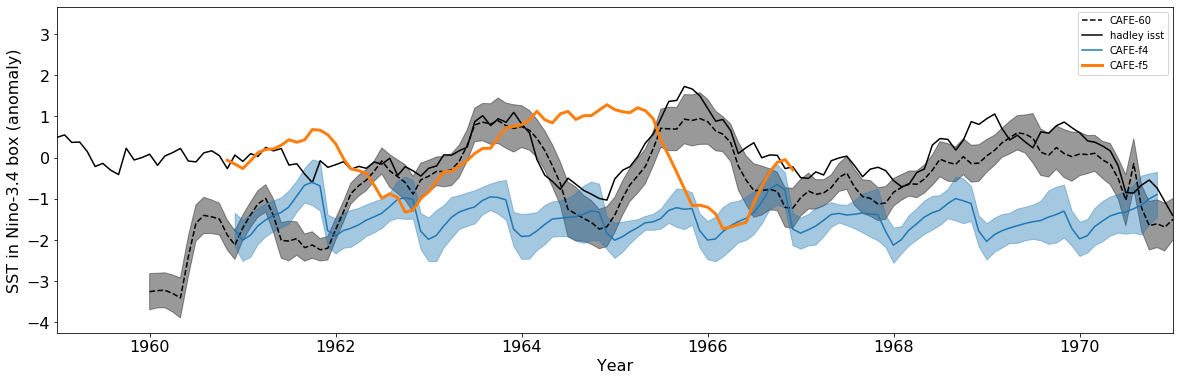

In [114]:
rc_params = {'figure.figsize' : [20.0, 6.0],
             'axes.titlesize' : 'medium',
             'font.size'      : 16,
             'font.family'    : 'sans serif'}
    
with mpl.rc_context(rc=rc_params):
    to_plot = d60_sst_anom
    to_plot_mean = to_plot.mean('ensemble')
    to_plot_std = to_plot.std('ensemble')
    plt.fill_between(to_plot.time.values, 
                     to_plot_mean - to_plot_std,
                     to_plot_mean + to_plot_std,
                     color='k', alpha=0.4, label='__nolegend__')
    plt.plot(to_plot.time.values,
             to_plot_mean, color='k', linestyle='--', label='CAFE-60')
    
    to_plot = had_sst_anom
    plt.plot(to_plot.time.values,
             to_plot, color='k', label='hadley isst')

#     to_plot = doppyo.utils.leadtime_to_datetime(gfdl_sst_anom.sel(init_date=init_date).squeeze())
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C1', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C1', label='gfdl cm2.1, cmip5-decpred')
    
#     to_plot = doppyo.utils.leadtime_to_datetime(cm4_sst_anom.sel(init_date=init_date).squeeze())
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C2', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C2', label='cmc cancm4, cmip5-decpred')
    
    to_plot = doppyo.utils.leadtime_to_datetime(f4_sst_anom.sel(init_date=init_date).squeeze())
    to_plot_mean = to_plot.mean('ensemble')
    to_plot_std = to_plot.std('ensemble')
    plt.fill_between(to_plot.time.values, 
                     to_plot_mean - to_plot_std,
                     to_plot_mean + to_plot_std,
                     color='C0', alpha=0.4, label='__nolegend__')
    plt.plot(to_plot.time.values,
             to_plot_mean, color='C0', label='CAFE-f4')
    
    to_plot = f5_sst_anom
    plt.plot(to_plot.time.values,
             to_plot, color='C1', label='CAFE-f5', linewidth=3)
    
    plt.xlim(np.datetime64(str(int(init_date)-1)),
             np.datetime64(str(int(init_date)+11)))
    plt.xlabel('Year')
    plt.ylabel('SST in Nino-3.4 box (anomaly)')
    
    plt.legend(fontsize=10)
    
    plt.savefig('figures/sst_nino34_anom.png', dpi=300, format='png', bbox_inches='tight')

# T_ref

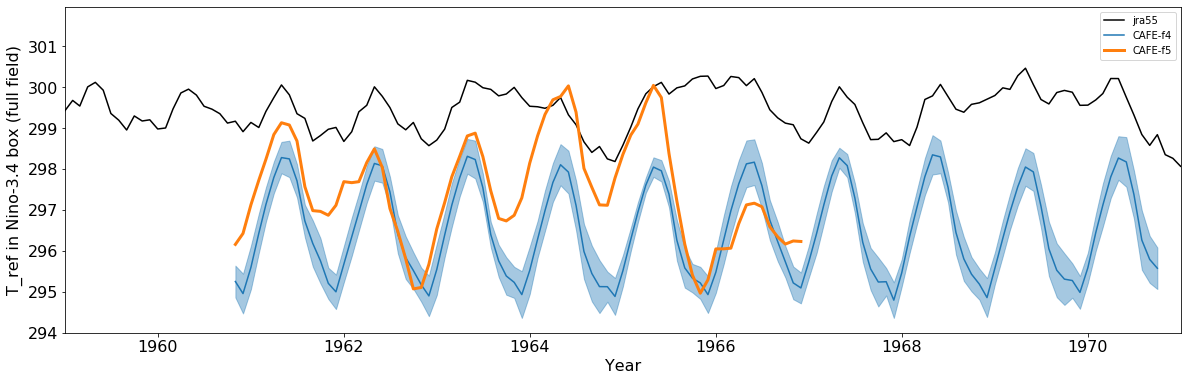

In [119]:
rc_params = {'figure.figsize' : [20.0, 6.0],
             'axes.titlesize' : 'medium',
             'font.size'      : 16,
             'font.family'    : 'sans serif'}
    
with mpl.rc_context(rc=rc_params):
    to_plot = jra_tref_full
    plt.plot(to_plot.time.values,
             to_plot, color='k', label='jra55')

#     to_plot = doppyo.utils.leadtime_to_datetime(gfdl_tref_full.sel(init_date=init_date).squeeze())
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C1', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C1', label='gfdl cm2.1, cmip5-decpred')
    
#     to_plot = doppyo.utils.leadtime_to_datetime(cm4_tref_full.sel(init_date=init_date).squeeze())
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C2', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C2', label='cmc cancm4, cmip5-decpred')
    
    to_plot = doppyo.utils.leadtime_to_datetime(f4_tref_full.sel(init_date=init_date).squeeze())
    to_plot_mean = to_plot.mean('ensemble')
    to_plot_std = to_plot.std('ensemble')
    plt.fill_between(to_plot.time.values, 
                     to_plot_mean - to_plot_std,
                     to_plot_mean + to_plot_std,
                     color='C0', alpha=0.4, label='__nolegend__')
    plt.plot(to_plot.time.values,
             to_plot_mean, color='C0', label='CAFE-f4')
    
    to_plot = f5_tref_full
    plt.plot(to_plot.time.values,
             to_plot, color='C1', label='CAFE-f5', linewidth=3)
    
    plt.xlim(np.datetime64(str(int(init_date)-1)),
             np.datetime64(str(int(init_date)+11)))
    plt.xlabel('Year')
    plt.ylabel('T_ref in Nino-3.4 box (full field)')
    
    plt.legend(fontsize=10)

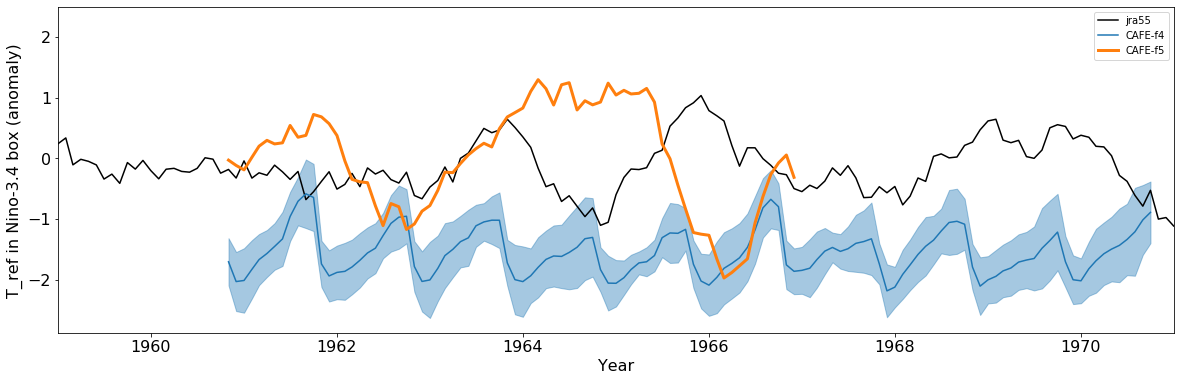

In [120]:
rc_params = {'figure.figsize' : [20.0, 6.0],
             'axes.titlesize' : 'medium',
             'font.size'      : 16,
             'font.family'    : 'sans serif'}
    
with mpl.rc_context(rc=rc_params):
    to_plot = jra_tref_anom
    plt.plot(to_plot.time.values,
             to_plot, color='k', label='jra55')

#     to_plot = doppyo.utils.leadtime_to_datetime(gfdl_tref_anom.sel(init_date=init_date).squeeze())
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C1', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C1', label='gfdl cm2.1, cmip5-decpred')
    
#     to_plot = doppyo.utils.leadtime_to_datetime(cm4_tref_anom.sel(init_date=init_date).squeeze())
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C2', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C2', label='cmc cancm4, cmip5-decpred')
    
    to_plot = doppyo.utils.leadtime_to_datetime(f4_tref_anom.sel(init_date=init_date).squeeze())
    to_plot_mean = to_plot.mean('ensemble')
    to_plot_std = to_plot.std('ensemble')
    plt.fill_between(to_plot.time.values, 
                     to_plot_mean - to_plot_std,
                     to_plot_mean + to_plot_std,
                     color='C0', alpha=0.4, label='__nolegend__')
    plt.plot(to_plot.time.values,
             to_plot_mean, color='C0', label='CAFE-f4')
    
    to_plot = f5_tref_anom
    plt.plot(to_plot.time.values,
             to_plot, color='C1', label='CAFE-f5', linewidth=3)
    
    plt.xlim(np.datetime64(str(int(init_date)-1)),
             np.datetime64(str(int(init_date)+11)))
    plt.xlabel('Year')
    plt.ylabel('T_ref in Nino-3.4 box (anomaly)')
    
    plt.legend(fontsize=10)

# SLP

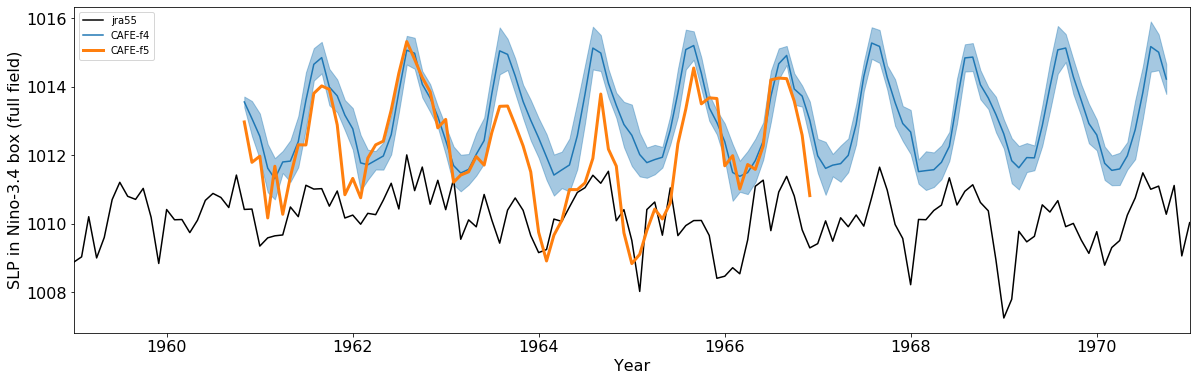

In [123]:
rc_params = {'figure.figsize' : [20.0, 6.0],
             'axes.titlesize' : 'medium',
             'font.size'      : 16,
             'font.family'    : 'sans serif'}
    
with mpl.rc_context(rc=rc_params):
    to_plot = jra_slp_full
    plt.plot(to_plot.time.values,
             to_plot, color='k', label='jra55')

#     to_plot = doppyo.utils.leadtime_to_datetime(gfdl_slp_full.sel(init_date=init_date).squeeze())
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C1', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C1', label='gfdl cm2.1, cmip5-decpred')
    
#     to_plot = doppyo.utils.leadtime_to_datetime(cm4_slp_full.sel(init_date=init_date).squeeze())
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C2', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C2', label='cmc cancm4, cmip5-decpred')
    
    to_plot = doppyo.utils.leadtime_to_datetime(f4_slp_full.sel(init_date=init_date).squeeze())
    to_plot_mean = to_plot.mean('ensemble')
    to_plot_std = to_plot.std('ensemble')
    plt.fill_between(to_plot.time.values, 
                     to_plot_mean - to_plot_std,
                     to_plot_mean + to_plot_std,
                     color='C0', alpha=0.4, label='__nolegend__')
    plt.plot(to_plot.time.values,
             to_plot_mean, color='C0', label='CAFE-f4')
    
    to_plot = f5_slp_full
    plt.plot(to_plot.time.values,
             to_plot, color='C1', label='CAFE-f5', linewidth=3)
    
    plt.xlim(np.datetime64(str(int(init_date)-1)),
             np.datetime64(str(int(init_date)+11)))
    plt.xlabel('Year')
    plt.ylabel('SLP in Nino-3.4 box (full field)')
    
    plt.legend(fontsize=10)

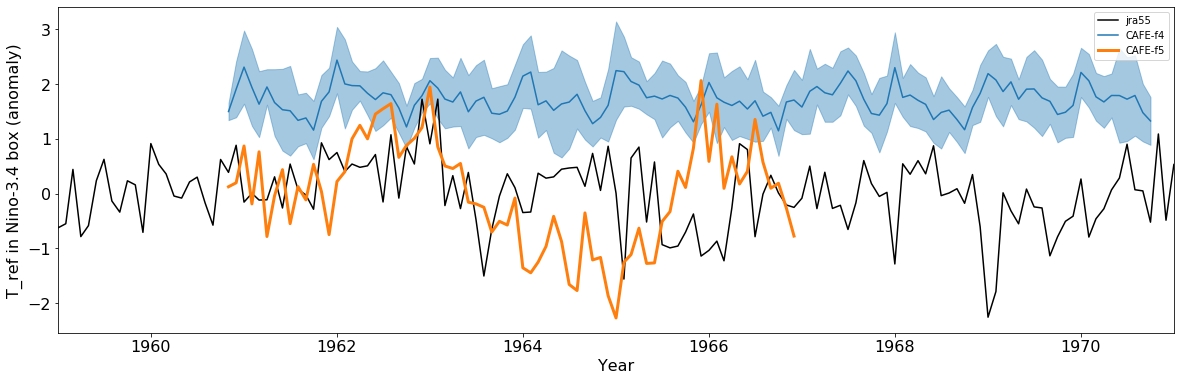

In [125]:
rc_params = {'figure.figsize' : [20.0, 6.0],
             'axes.titlesize' : 'medium',
             'font.size'      : 16,
             'font.family'    : 'sans serif'}
    
with mpl.rc_context(rc=rc_params):
    to_plot = jra_slp_anom
    plt.plot(to_plot.time.values,
             to_plot, color='k', label='jra55')

#     to_plot = doppyo.utils.leadtime_to_datetime(gfdl_slp_anom.sel(init_date=init_date).squeeze())
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C1', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C1', label='gfdl cm2.1, cmip5-decpred')
    
#     to_plot = doppyo.utils.leadtime_to_datetime(cm4_slp_anom.sel(init_date=init_date).squeeze())
#     to_plot_mean = to_plot.mean('ensemble')
#     to_plot_std = to_plot.std('ensemble')
#     plt.fill_between(to_plot.time.values, 
#                      to_plot_mean - to_plot_std,
#                      to_plot_mean + to_plot_std,
#                      color='C2', alpha=0.4, label='__nolegend__')
#     plt.plot(to_plot.time.values,
#              to_plot_mean, color='C2', label='cmc cancm4, cmip5-decpred')
    
    to_plot = doppyo.utils.leadtime_to_datetime(f4_slp_anom.sel(init_date=init_date).squeeze())
    to_plot_mean = to_plot.mean('ensemble')
    to_plot_std = to_plot.std('ensemble')
    plt.fill_between(to_plot.time.values, 
                     to_plot_mean - to_plot_std,
                     to_plot_mean + to_plot_std,
                     color='C0', alpha=0.4, label='__nolegend__')
    plt.plot(to_plot.time.values,
             to_plot_mean, color='C0', label='CAFE-f4')
    
    to_plot = f5_slp_anom
    plt.plot(to_plot.time.values,
             to_plot, color='C1', label='CAFE-f5', linewidth=3)
    
    plt.xlim(np.datetime64(str(int(init_date)-1)),
             np.datetime64(str(int(init_date)+11)))
    plt.xlabel('Year')
    plt.ylabel('T_ref in Nino-3.4 box (anomaly)')
    
    plt.legend(fontsize=10)